In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from math import ceil
from CIoTS import *
from tqdm import trange

/home/marcus/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
runs = 20
max_p = 22
dimensions = 3
data_length = 10000
alpha = 0.05

In [4]:
ics = ["aic", "bic", "hqic"]

In [5]:
p_estimations = pd.DataFrame(columns=['p' ,'method', 'mean_p', 'std_p'])
scores = pd.DataFrame(columns=['p' ,'method', 'mean_f1', 'std_f1', 'mean_recall', 'std_recall',
                               'mean_precision', 'std_precision', 'mean_fpr', 'std_fpr'])

In [ ]:
for p in trange(2, max_p, 2):
    incoming_edges = 3
    f1 = {ic: [] for ic in ics}
    f1.update({'incremental_' + ic: [] for ic in ics})
    f1['real'] = []
    
    precision = {ic: [] for ic in ics}
    precision.update({'incremental_' + ic: [] for ic in ics})
    precision['real'] = []
    
    recall = {ic: [] for ic in ics}
    recall.update({'incremental_' + ic: [] for ic in ics})
    recall['real'] = []
    
    fpr = {ic: [] for ic in ics}
    fpr.update({'incremental_' + ic: [] for ic in ics})
    fpr['real'] = []
    
    p_est = {ic: [] for ic in ics}
    p_est.update({'incremental_' + ic: [] for ic in ics})
    
    for i in trange(runs):
        generator = CausalTSGenerator(dimensions=dimensions, max_p=p, data_length=data_length,
                                      incoming_edges=incoming_edges)
        ts = generator.generate()
        predicted_graph = pc_chen_modified(partial_corr_test, ts, p, alpha)
        
        eval_result = evaluate_edges(generator.graph, predicted_graph)
        f1['real'].append(eval_result['f1-score'])
        recall['real'].append(eval_result['TPR'])
        fpr['real'].append(eval_result['FPR'])
        precision['real'].append(eval_result['precision'])
        
        # VAR estimation
        var_ranking, var_scores = var_order_select(ts, 2*(max_p-2), ics, drop=True) 
        for ic in ics:
            predicted_graph = pc_chen_modified(partial_corr_test, ts, var_ranking[ic][0], alpha)
            eval_result = evaluate_edges(generator.graph, predicted_graph)
            
            p_est[ic].append(var_ranking[ic][0])
            f1[ic].append(eval_result['f1-score'])
            recall[ic].append(eval_result['TPR'])
            fpr[ic].append(eval_result['FPR'])
            precision[ic].append(eval_result['precision'])
        
        # incremental
        for ic in ics:
            predicted_graph = pc_incremental(partial_corr_test, ts, 0.05, 2*(max_p-2), ic=ic)
            eval_result = evaluate_edges(generator.graph, predicted_graph)
            
            p_est['incremental_' + ic].append(len(predicted_graph.nodes())/dimensions - 1)
            f1['incremental_' + ic].append(eval_result['f1-score'])
            recall['incremental_' + ic].append(eval_result['TPR'])
            fpr['incremental_' + ic].append(eval_result['FPR'])
            precision['incremental_' + ic].append(eval_result['precision'])
    
    
    scores = scores.append({'p': p, 'method': 'real',
                            'mean_f1': np.mean(f1['real']), 'std_f1': np.std(f1['real']),
                            'mean_recall': np.mean(recall['real']), 'std_recall': np.std(recall['real']),
                            'mean_precision': np.mean(precision['real']), 'std_precision': np.std(precision['real']),
                            'mean_fpr': np.mean(fpr['real']), 'std_fpr': np.std(fpr['real'])},
                           ignore_index=True)
    for ic in ics:
        p_estimations = p_estimations.append({'p': p, 'method': ic, 'mean_p': np.mean(p_est[ic]), 
                                              'std_p': np.std(p_est[ic])},
                                             ignore_index=True)
        scores = scores.append({'p': p, 'method': ic,
                                'mean_f1': np.mean(f1[ic]), 'std_f1': np.std(f1[ic]),
                                'mean_recall': np.mean(recall[ic]), 'std_recall': np.std(recall[ic]),
                                'mean_precision': np.mean(precision[ic]), 'std_precision': np.std(precision[ic]),
                                'mean_fpr': np.mean(fpr[ic]), 'std_fpr': np.std(fpr[ic])},
                               ignore_index=True)
   
    for ic in ics:
        p_estimations = p_estimations.append({'p': p, 'method': 'incremental_' + ic, 
                                              'mean_p': np.mean(p_est['incremental_' + ic]),
                                              'std_p': np.std(p_est['incremental_' + ic])},
                                             ignore_index=True)
        scores = scores.append({'p': p, 'method': 'incremental_' + ic,
                                'mean_f1': np.mean(f1['incremental_' + ic]), 'std_f1': np.std(f1['incremental_' + ic]),
                                'mean_recall': np.mean(recall['incremental_' + ic]),
                                'std_recall': np.std(recall['incremental_' + ic]),
                                'mean_precision': np.mean(precision['incremental_' + ic]),
                                'std_precision': np.std(precision['incremental_' + ic]),
                                'mean_fpr': np.mean(fpr['incremental_' + ic]),
                                'std_fpr': np.std(fpr['incremental_' + ic])},
                               ignore_index=True)
    

In [7]:
scores.to_csv('scores_drop.csv')
p_estimations.to_csv('p_estimations_drop.csv')

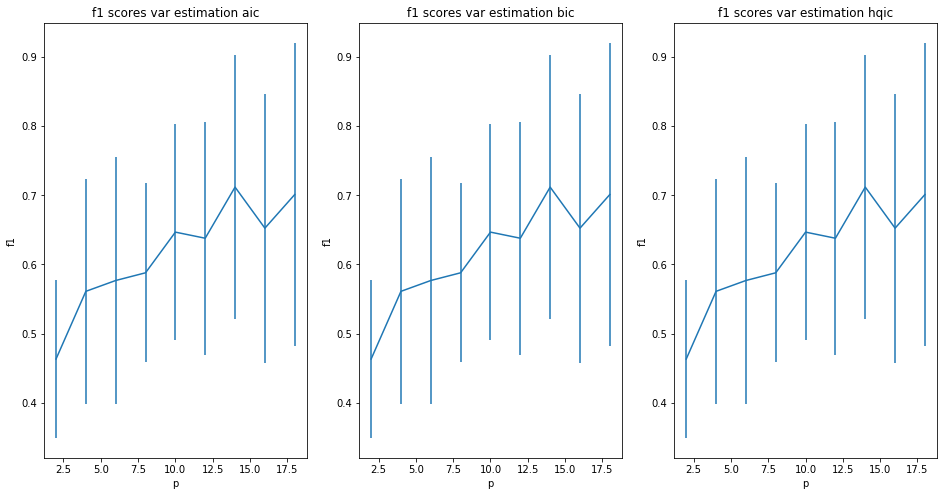

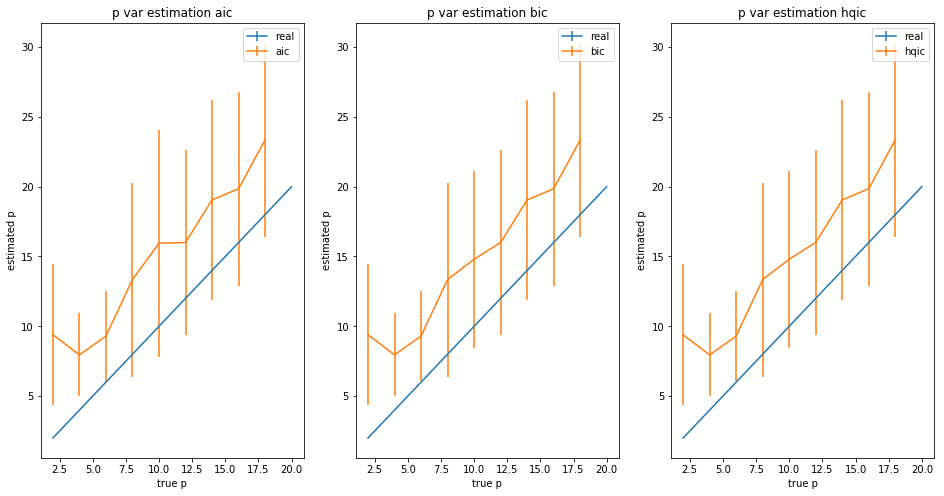

In [8]:
plt.figure(figsize=(16,8))
for i in range(len(ics)):
    plt.subplot(1, len(ics), i+1)
    ic = ics[i]
    plt.title('f1 scores var estimation ' + ic)
    plt.xlabel('p')
    plt.ylabel('f1')
    plt.errorbar(x=scores.loc[scores['method']==ic, 'p'],
                 y=scores.loc[scores['method']==ic, 'mean_f1'],
                 yerr=scores.loc[scores['method']==ic, 'std_f1'],
                 label=ic)
    #plt.legend()
plt.show()


plt.figure(figsize=(16,8))
for i in range(len(ics)):
    plt.subplot(1, len(ics), i+1)
    ic = ics[i]
    plt.title('p var estimation ' + ic)
    plt.xlabel('true p')
    plt.ylabel('estimated p')
    plt.errorbar(x=np.arange(2, 22, 2),
                 y=np.arange(2, 22, 2),
                 yerr=0,
                 label='real')
    plt.errorbar(x=p_estimations.loc[p_estimations['method']==ic, 'p'],
                 y=p_estimations.loc[p_estimations['method']==ic, 'mean_p'],
                 yerr=p_estimations.loc[p_estimations['method']==ic, 'std_p'],
                 label=ic)
    plt.legend()
plt.show()

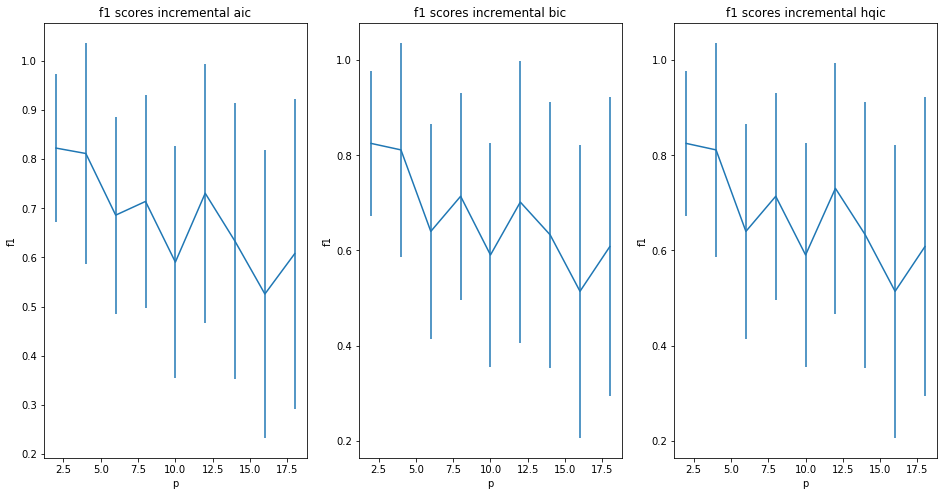

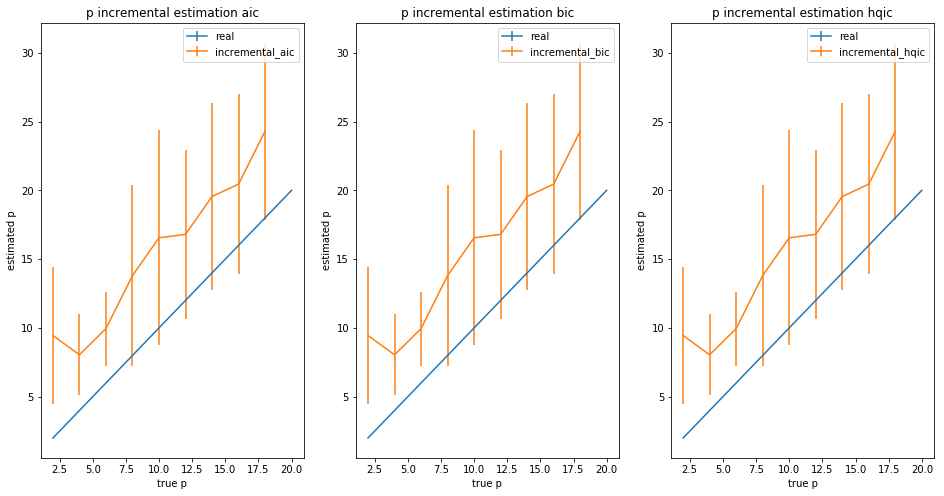

In [9]:
plt.figure(figsize=(16,8))
for i in range(len(ics)):
    plt.subplot(1, len(ics), i+1)
    ic = ics[i]
    plt.title('f1 scores incremental ' + ic)
    plt.xlabel('p')
    plt.ylabel('f1')
    plt.errorbar(x=scores.loc[scores['method']=='incremental_' + ic, 'p'],
                 y=scores.loc[scores['method']=='incremental_' + ic, 'mean_f1'],
                 yerr=scores.loc[scores['method']=='incremental_' + ic, 'std_f1'],
                 label='incremental_' + ic)
    # plt.legend()
plt.show()


plt.figure(figsize=(16,8))
for i in range(len(ics)):
    plt.subplot(1, len(ics), i+1)
    ic = ics[i]
    plt.title('p incremental estimation ' + ic)
    plt.xlabel('true p')
    plt.ylabel('estimated p')
    plt.errorbar(x=np.arange(2, 22, 2),
                 y=np.arange(2, 22, 2),
                 yerr=0,
                 label='real')
    plt.errorbar(x=p_estimations.loc[p_estimations['method']=='incremental_' + ic, 'p'],
                 y=p_estimations.loc[p_estimations['method']=='incremental_' + ic, 'mean_p'],
                 yerr=p_estimations.loc[p_estimations['method']=='incremental_' + ic, 'std_p'],
                 label='incremental_' + ic)
    plt.legend()
plt.show()

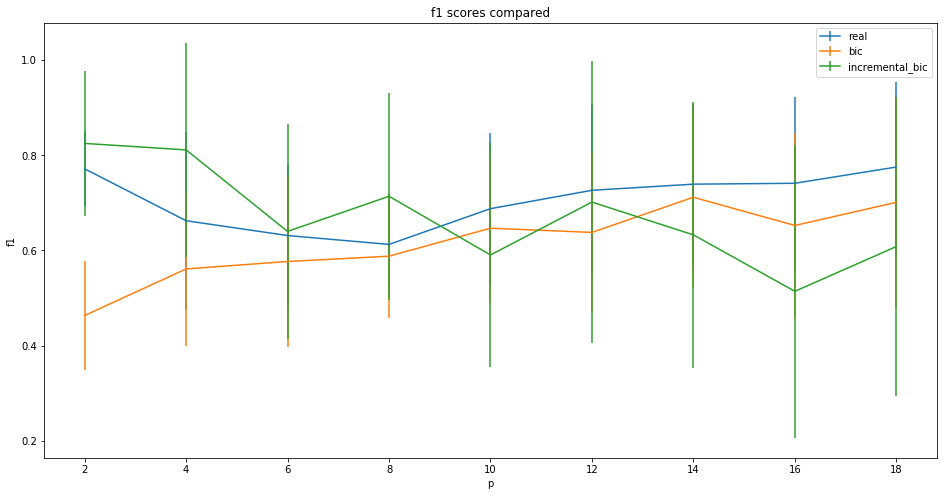

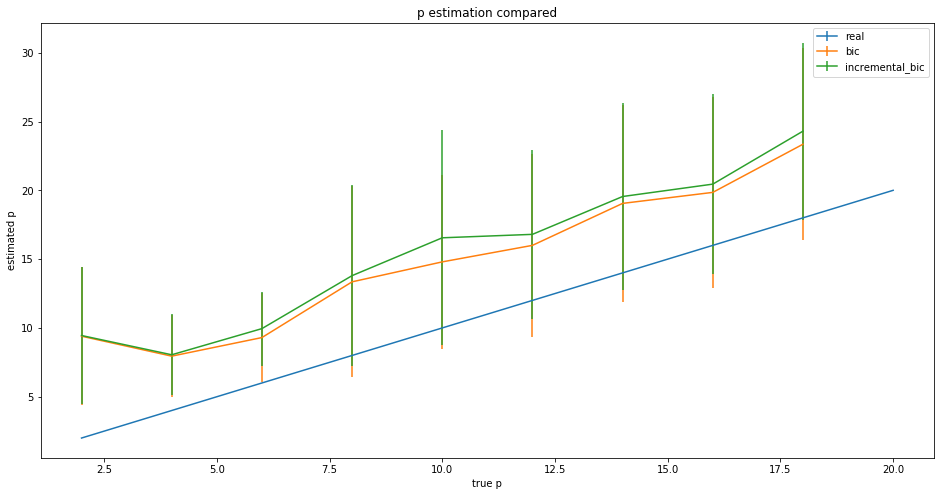

In [10]:
plt.figure(figsize=(16,8))
plt.title('f1 scores compared')
plt.xlabel('p')
plt.ylabel('f1')
plt.errorbar(x=scores.loc[scores['method']=='real', 'p'],
             y=scores.loc[scores['method']=='real', 'mean_f1'],
             yerr=scores.loc[scores['method']=='real', 'std_f1'],
             label='real')
plt.errorbar(x=scores.loc[scores['method']=='bic', 'p'],
             y=scores.loc[scores['method']=='bic', 'mean_f1'],
             yerr=scores.loc[scores['method']=='bic', 'std_f1'],
             label='bic')
plt.errorbar(x=scores.loc[scores['method']=='incremental_bic', 'p'],
             y=scores.loc[scores['method']=='incremental_bic', 'mean_f1'],
             yerr=scores.loc[scores['method']=='incremental_bic', 'std_f1'],
             label='incremental_bic')
plt.legend()
plt.show()


plt.figure(figsize=(16,8))
plt.title('p estimation compared')
plt.xlabel('true p')
plt.ylabel('estimated p')
plt.errorbar(x=np.arange(2, 22, 2),
             y=np.arange(2, 22, 2),
             yerr=0,
             label='real')
plt.errorbar(x=p_estimations.loc[p_estimations['method']=='bic', 'p'],
             y=p_estimations.loc[p_estimations['method']=='bic', 'mean_p'],
             yerr=p_estimations.loc[p_estimations['method']=='bic', 'std_p'],
             label='bic')
plt.errorbar(x=p_estimations.loc[p_estimations['method']=='incremental_bic', 'p'],
             y=p_estimations.loc[p_estimations['method']=='incremental_bic', 'mean_p'],
             yerr=p_estimations.loc[p_estimations['method']=='incremental_bic', 'std_p'],
             label='incremental_bic')
plt.legend()
plt.show()
